## Processing Data

In [1]:
%reset -fs
from collections import Counter
import random
import os
import sys
sys.path.append('..')
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
EXPECTED_BYTES = 31344016
DATA_FOLDER = 'data/'
FILE_NAME = 'text8.zip'


def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
    	pass

def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    file_path = DATA_FOLDER + file_name
    if os.path.exists(file_path):
        print("Dataset ready")
        return file_path
    file_name, _ = urllib.request.urlretrieve(DOWNLOAD_URL + file_name, file_path)
    file_stat = os.stat(file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return file_path    
    
    
def read_data(file_path):
    """ Read data into a list of tokens"""
    with zipfile.ZipFile(file_path) as f:
        words = tf.compat.as_str(f.read(f.namelist()[0])).split()
        # tf.compat.as_str() converts the input into the string
    return words

def build_vocab(words, vocab_size):
    """ Build vocabulary of VOCAB_SIZE most frequent words """
    dictionary = dict()
    count = [('UNK', -1)]
    count.extend(Counter(words).most_common(vocab_size - 1))
    index = 0
    make_dir('processed')
    with open('processed/vocab_1000.tsv', "w") as f:
        for word, _ in count:
            dictionary[word] = index
            if index < 1000:
                f.write(word + "\n")
            index += 1
    index_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    #dictionary是word對應到index
    #index_dictionary是index對應到單字
    return dictionary, index_dictionary

def convert_words_to_index(words, dictionary):
    """ Replace each word in the dataset with its index in the dictionary """
    return [dictionary[word] if word in dictionary else 0 for word in words]

def generate_sample(index_words, context_window_size):
    """ Form training pairs according to the CBoW model. """
    for index, center in enumerate(index_words): #enumerate: 同時得到 index, element
        if index != 0 and index != len(index_words)-1: #目前的字不是第一個也不是最後一個
            target1 = index_words[index-1]
            target2 = index_words[index+1]
            yield [target1, target2], center
            
"""    for index, center in enumerate(index_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in index_words[max(0, index - context): index]:
            yield center, target
        # get a random target after the center wrod
        for target in index_words[index + 1: index + context + 1]:
            yield center, target"""

def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        target_batch = np.zeros([batch_size, 2], dtype=np.int32)
        center_batch = np.zeros([batch_size, 1])
        #target_batch = np.zeros([batch_size, 2])
        for index in range(batch_size):
            target_batch[index], center_batch[index]= next(iterator)
        yield target_batch, center_batch
        
def get_batch_gen(index_words, context_window_size, batch_size):
    """ Return a python generator that generates batches"""
    single_gen = generate_sample(index_words, context_window_size)
    batch_gen = get_batch(single_gen, batch_size)
    return batch_gen
        
def process_data(vocab_size):
    """Read data, build vocabulary and dictionary"""
    file_path = download(FILE_NAME, EXPECTED_BYTES)
    words = read_data(file_path)
    dictionary, index_dictionary = build_vocab(words, vocab_size) #dict is word:index； index_dict is index:word
    index_words = convert_words_to_index(words, dictionary) # convert all words into indices
    del words # to save mem
    return index_words, dictionary, index_dictionary

/home/rohan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


由於 CBOW 的 training data 和原先的並不同，所以我們必須要改變 generate data 的方式。    
最主要的差別是，我們將除了第一個和最後一個的字都當作 center 一遍，並找出這個 center 的前一個和後一個字當作 targets，藉此做出 training data。    
這裡要注意的是，由於我們要讓 targets 的兩個字作為學習的對象，所以在宣告各種變數時，要注意 container 都要改成能放兩個維度來存。
這部份我發現一個小問題，就是我必須先創好 data 資料夾才能順利讓 code 將檔案下載下來並放進去，這令我滿疑惑的而且我沒有解決這個問題。

## Build the Model

In [2]:
from __future__ import absolute_import # use absolute import instead of relative import

# '/' for floating point division, '//' for integer division
from __future__ import division  
from __future__ import print_function  # use 'print' as a function

import os

import numpy as np
import tensorflow as tf

class CBOW:
    
    """ Build the graph for word2vec model """
    def __init__(self, hparams=None):
        if hparams is None:
            self.hps = get_default_hparams()
        else:
            self.hps = hparams
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
    def _create_input(self):
        """Step 1: define input and output"""
        with tf.name_scope("data"):
            self.targets = tf.placeholder(tf.int32, [self.hps.num_pairs, 2], name='targets')
            self.centers = tf.placeholder(tf.int32, [self.hps.num_pairs, 1], name='centers')
            #self.targets1 = tf.placeholder(tf.int32, [self.hps.num_pairs, 1], name='targets')
            #self.targets2 = tf.placeholder(tf.int32, [self.hps.num_pairs, 1], name='targets') #兩個targets
            
            dataset = tf.contrib.data.Dataset.from_tensor_slices((self.targets, self.centers))
            dataset = dataset.repeat() # # Repeat the input indefinitely
            dataset = dataset.batch(self.hps.batch_size)

            
            self.iterator = dataset.make_initializable_iterator()  # create iterator
            self.target_words, self.center_words = self.iterator.get_next()
            #self.center_words, self.target_words1, self.target_words2 = self.iterator.get_next()
            
    def _create_embedding(self):
        """ Step 2: define weights. 
        In word2vec, it's actually the weights that we care about"""
        with tf.device('/gpu:0'):
            with tf.name_scope("embed"):
                self.embed_matrix = tf.Variable(tf.random_uniform([self.hps.vocab_size,
                                                               self.hps.embed_size], -1.0, 1.0), name='embed_matrix')
    
    def _create_loss(self):
        """ Step 3 + 4: define the model + the loss function """
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                # Step 3: define the inference
                embed_ = tf.nn.embedding_lookup(self.embed_matrix, self.target_words, name='embed')

                embed = tf.reduce_sum(embed_, 1)
                
                # Step 4: define loss function
                # construct variables for NCE loss
                nce_weight = tf.Variable(
                                tf.truncated_normal([self.hps.vocab_size, self.hps.embed_size],
                                                    stddev=1.0 / (self.hps.embed_size ** 0.5)),
                                                    name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([self.hps.vocab_size]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                          biases=nce_bias,
                                                          #labels=self.target_words,
                                                          labels=self.center_words,
                                                          inputs=embed,
                                                          num_sampled=self.hps.num_sampled,
                                                          num_classes=self.hps.vocab_size), name='loss') 
        
    def _create_optimizer(self):
        """ Step 5: define optimizer """
        with tf.device('/gpu:0'):
            self.optimizer = tf.train.AdamOptimizer(self.hps.lr).minimize(self.loss,
                                                             global_step=self.global_step)
        
        
    def _build_nearby_graph(self):
        # Nodes for computing neighbors for a given word according to
        # their cosine distance.
        self.nearby_word = tf.placeholder(dtype=tf.int32)  # word id
        nemb = tf.nn.l2_normalize(self.embed_matrix, 1)
        nearby_emb = tf.gather(nemb, self.nearby_word)
        nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
        self.nearby_val, self.nearby_idx = tf.nn.top_k(nearby_dist, min(1000, self.hps.vocab_size)) 
        
        
    def _build_eval_graph(self):
        """Build the eval graph."""
        # Eval graph

        # Each analogy task is to predict the 4th word (d) given three
        # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
        # predict d=paris.

        # The eval feeds three vectors of word ids for a, b, c, each of
        # which is of size N, where N is the number of analogies we want to
        # evaluate in one batch.
        self.analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
        self.analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
        self.analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

        # Normalized word embeddings of shape [vocab_size, emb_dim].
        nemb = tf.nn.l2_normalize(self.embed_matrix, 1)

        # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
        # They all have the shape [N, emb_dim]
        a_emb = tf.gather(nemb, self.analogy_a)  # a's embs
        b_emb = tf.gather(nemb, self.analogy_b)  # b's embs
        c_emb = tf.gather(nemb, self.analogy_c)  # c's embs

        # We expect that d's embedding vectors on the unit hyper-sphere is
        # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
        target = c_emb + (b_emb - a_emb)

        # Compute cosine distance between each pair of target and vocab.
        # dist has shape [N, vocab_size].
        dist = tf.matmul(target, nemb, transpose_b=True)

        # For each question (row in dist), find the top 20 words.
        _, self.pred_idx = tf.nn.top_k(dist, 20)
        
        
    def predict(self, sess, analogy):
        """ Predict the top 20 answers for analogy questions """
        idx, = sess.run([self.pred_idx], {
            self.analogy_a: analogy[:, 0],
            self.analogy_b: analogy[:, 1],
            self.analogy_c: analogy[:, 2]
        })
        return idx
    
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()
  
            
    def build_graph(self):
        """ Build the graph for our model """
        self._create_input()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._build_eval_graph()
        self._build_nearby_graph()
        self._create_summaries()

        
def train_model(sess, model, batch_gen, index_words, num_train_steps):
    saver = tf.train.Saver()# Saver:存變數
    # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    initial_step = 0
    make_dir('checkpoints') # directory to store checkpoints


  
    sess.run(tf.global_variables_initializer()) # initialize all variables
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('./checkpoints/checkpoint'))
    # if that checkpoint exists, restore from checkpoint
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    total_loss = 0.0 # use this to calculate late average loss in the last SKIP_STEP steps
    writer = tf.summary.FileWriter('graph/lr' + str(model.hps.lr), sess.graph)
    initial_step = model.global_step.eval()
    for index in range(initial_step, initial_step + num_train_steps):
    # feed in new dataset  
        if index % model.hps.new_dataset_every == 0:
            try:
                targets, centers = next(batch_gen)
            except StopIteration: # generator has nothing left to generate
                batch_gen = get_batch_gen(index_words, 
                                          model.hps.skip_window, 
                                          model.hps.num_pairs)
                targets, centers = next(batch_gen)
                print('Finished looking at the whole text')
            
            feed = {
                model.targets: targets,
                model.centers: centers
             }
            _ = sess.run(model.iterator.initializer, feed_dict = feed)
            print('feeding in new dataset')
      
        loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op])
        writer.add_summary(summary, global_step=index)
        total_loss += loss_batch
        if (index + 1) % model.hps.skip_step == 0:
            print('Average loss at step {}: {:5.1f}'.format(index,
                                                            total_loss/model.hps.skip_step))
            total_loss = 0.0
            saver.save(sess, 'checkpoints/skip-gram', index)
            
            
def get_default_hparams():
    hparams = tf.contrib.training.HParams(
        num_pairs = 10**6,                # number of (center, target) pairs 
                                          # in each dataset instance
        vocab_size = 10000,
        batch_size = 128,
        embed_size = 300,                 # dimension of the word embedding vectors
        skip_window = 3,                  # the context window
        num_sampled = 100,                # number of negative examples to sample
        lr = 0.005,                       # learning rate
        new_dataset_every = 10**4,          # replace the original dataset every ? steps
        num_train_steps = 2*10**5,      # number of training steps for each feed of dataset 
                                          # 2*10**5
        skip_step = 2000
    )
    return hparams
    
def main():
    hps = get_default_hparams()
    index_words, dictionary, index_dictionary = process_data(hps.vocab_size)
    batch_gen = get_batch_gen(index_words, hps.skip_window, hps.num_pairs)

    model = CBOW(hparams = hps)
    model.build_graph()


    with tf.Session() as sess:
    # feed the model with dataset
        targets, centers= next(batch_gen)
        feed = {
            model.targets: targets,
            model.centers: centers
        }
        sess.run(model.iterator.initializer, feed_dict = feed) # initialize the iterator

        train_model(sess, model, batch_gen, index_words, hps.num_train_steps)

if __name__ == '__main__':
    main()

Dataset ready
Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.
feeding in new dataset
Average loss at step 1999:  48.0
Average loss at step 3999:   6.7
Average loss at step 5999:   6.4
Average loss at step 7999:   7.2
Average loss at step 9999:   7.1
feeding in new dataset
Average loss at step 11999:   7.7
Average loss at step 13999:   6.9
Average loss at step 15999:   7.3
Average loss at step 17999:   7.4
Average loss at step 19999:   6.2
feeding in new dataset
Average loss at step 21999:   7.2
Average loss at step 23999:   7.3
Average loss at step 25999:   7.4
Average loss at step 27999:   7.4
Average loss at step 29999:   6.1
feeding in new dataset
Average loss at step 31999:   6.9
Average loss at step 33999:   7.6
Average loss at step 35999:   7.6
Average loss at step 37999:   7.2
Average loss at step 39999:   5.7
feeding in new dataset
Average loss at step 41999:   7.5
Average loss at step 43999:   7.7
Average loss at step 45999:   7.4
Average loss at step 47

/home/rohan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:178: DeprecationWarning: generator 'get_batch' raised StopIteration


Finished looking at the whole text
feeding in new dataset
Average loss at step 161999:   7.7
Average loss at step 163999:   7.8
Average loss at step 165999:   7.5
Average loss at step 167999:   7.2
Average loss at step 169999:   6.4
feeding in new dataset
Average loss at step 171999:   7.3
Average loss at step 173999:   7.9
Average loss at step 175999:   7.7
Average loss at step 177999:   7.6
Average loss at step 179999:   6.1
feeding in new dataset
Average loss at step 181999:   7.9
Average loss at step 183999:   7.5
Average loss at step 185999:   8.2
Average loss at step 187999:   7.9
Average loss at step 189999:   6.4
feeding in new dataset
Average loss at step 191999:   7.8
Average loss at step 193999:   7.8
Average loss at step 195999:   7.9
Average loss at step 197999:   7.8
Average loss at step 199999:   6.4


正如前面所提到，我們在宣告 placeholder 時，由於我們已經改過 training data 的產生方式，所以必須要注意 data 的維度，也就是要把 targets 設定成 2 維。    
接著，在 create loss 的部份，由於我們使用了兩個 targets，所以我們在 look up 以後會得到兩個值。我的作法是將他們加起來作為一個值來繼續之後的 training 部份。     
由於這部份的 code 會開兩個資料夾 graph 和 checkpoints，我發現每次我在跑 code 的時候都必須先把檔案刪掉再重跑，否則會出錯，不曉得是原先就有這個問題或是我創資料夾的方法有誤。    
此外，我在測試的時候，如果跑失敗一次，改完 code 後想再重跑一次 CBOWModel 這部份的話， 都會跳出要求我必須重新 initialize 的錯誤。 我沒有找到解決得辦法，只好將code halt and close 後再重新跑一遍我改過的部份才會正常。不曉得造成這個問題的原因和解決辦法是什麼？



In [3]:
import os
import tensorflow as tf
#from process_data import process_data
#from train import get_default_hparams, SkipGramModel

#Clears the default graph stack and resets the global default graph
tf.reset_default_graph() 
hps = get_default_hparams()
# get dictionary 
index_words, dictionary, index_dictionary = process_data(hps.vocab_size)

# build model
model = CBOW(hps)
model.build_graph()

# initialize variables and restore checkpoint
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
saver.restore(sess, ckpt.model_checkpoint_path)

Dataset ready
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-199999


In [11]:
import numpy as np

def nearby(words, model, sess, dictionary, index_dictionary, num=10):
    """Prints out nearby words given a list of words."""
    ids = np.array([dictionary.get(x, 0) for x in words])
    vals, idx = sess.run([model.nearby_val, model.nearby_idx], {model.nearby_word: ids})
    for i in range(len(words)):
        print("\n%s\n=====================================" % (words[i]))
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (index_dictionary.get(neighbor), distance))
        
def analogy(line, model, sess, dictionary, index_dictionary):
    """ Prints the top k anologies for a given array which contain 3 words"""
    analogy = np.array([dictionary.get(w, 0) for w in line])[np.newaxis,:]
    idx = model.predict(sess, analogy)
    print(line)
    for i in idx[0]:
        print(index_dictionary[i])

words = ['word', 'two', 'vector']
nearby(words, model, sess, dictionary, index_dictionary)



word
word                 1.0000
term                 0.4098
name                 0.4033
words                0.3957
apply                0.3515
to                   0.3481
register             0.3467
latin                0.3424
greek                0.3423
possibility          0.3411

two
two                  1.0000
three                0.7210
one                  0.7028
four                 0.6232
nine                 0.6154
five                 0.6094
six                  0.5969
zero                 0.5701
eight                0.5666
seven                0.5438

vector
vector               1.0000
model                0.3894
digital              0.3776
one                  0.3488
b                    0.3480
costume              0.3472
c                    0.3467
descriptions         0.3439
three                0.3433
operator             0.3407


從結果可以看到，word 和 vector 的前 10 名都是比較接近的字，不過跟理想情況還是有差距，原因應該是我的參數調整得並不是很好。    
不過在 two 的部份就能明顯看到相關的字大多表現得很明顯。




In [12]:
analogy(['london', 'england', 'berlin'], model, sess, dictionary, index_dictionary)

['london', 'england', 'berlin']
england
berlin
licenses
alliance
zimbabwe
louisiana
bandwidth
traced
china
stops
runner
trends
rain
afterwards
defendant
bismarck
absinthe
delhi
malaysia
beavis


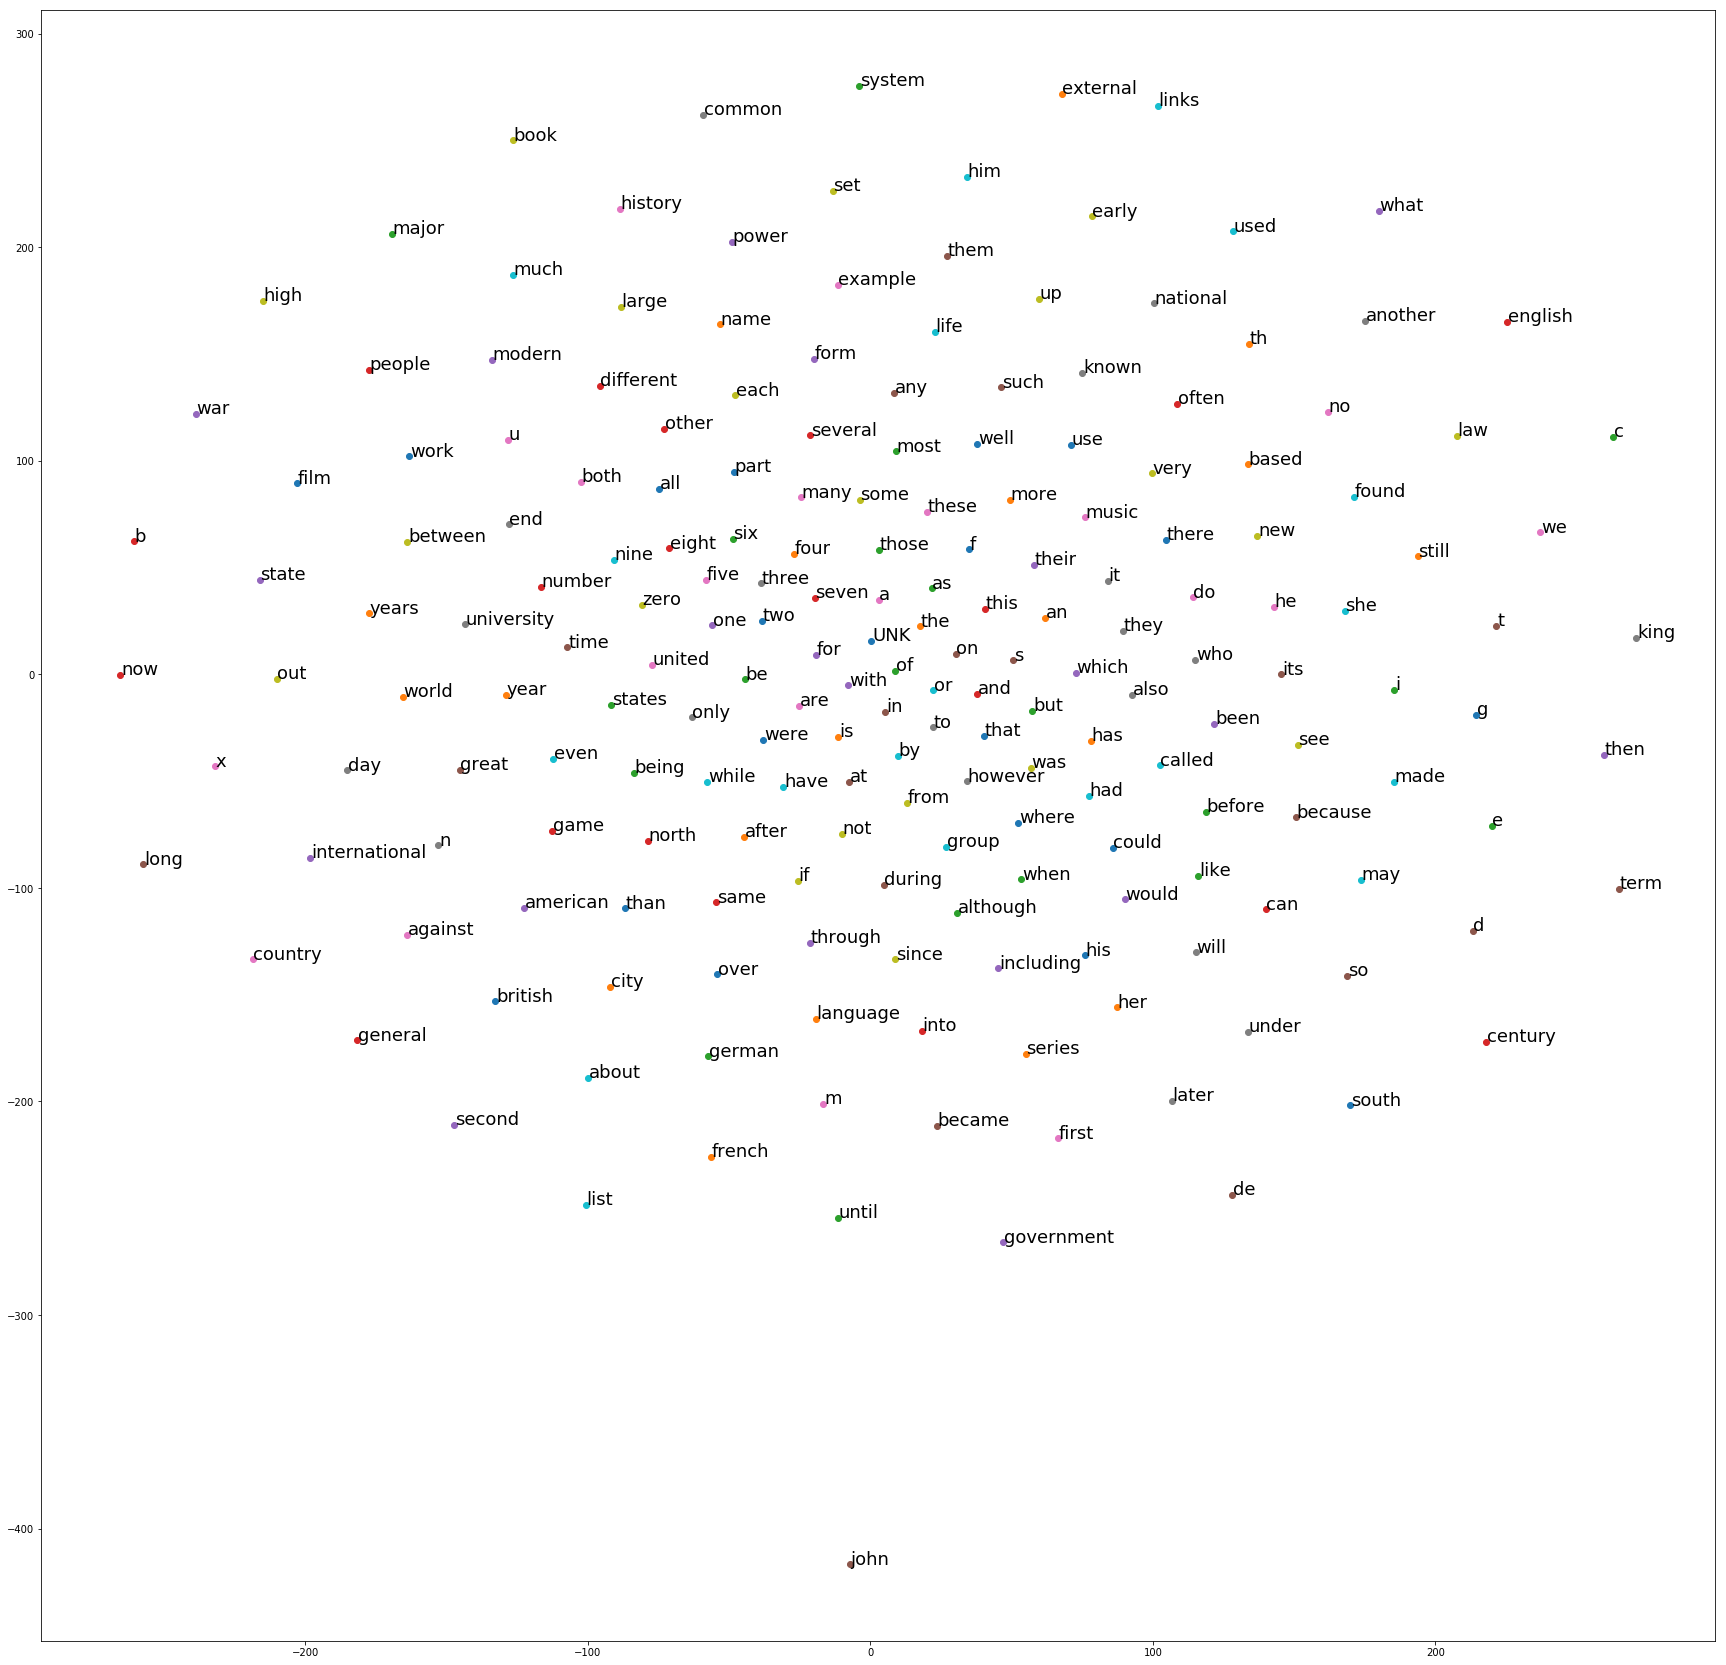

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

rng = 200

embed_matrix = sess.run(model.embed_matrix) # get the embed matrix

X_embedded = TSNE(n_components=2).fit_transform(embed_matrix[:rng])

plt.figure(figsize=(30,30))

for i in range(rng):
    plt.scatter(X_embedded[i][0], X_embedded[i][1])
    plt.text(X_embedded[i][0]+0.2,
             X_embedded[i][1]+0.2,
             index_dictionary.get(i, 0), fontsize=18)

    
plt.show()

